# Проект для «Викишоп»

## Подготовка

### Импорт инструментов для работы

Импортируем необходимые библиотеки, функции, модели, классы, фреймворки:

In [1]:
import pandas as pd
import numpy as np
import re 
import spacy
import optuna
import nltk

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from nltk.probability import FreqDist
from tqdm import notebook 
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import TextClassificationPipeline, AutoTokenizer, AutoModelForSequenceClassification

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

2023-05-02 23:54:03.689454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Загрузка данных

Импортируем датафрейм:

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.sample(n=5)

,text,toxic
53562,break stuff? \n\ndid you really break things w...,0
90050,Would you mind telling me why? It would help m...,0
3599,REDIRECT Talk:Dysfunctional (Tech N9ne song),0
82471,"Nice changes to Football (soccer) \n\nHi Hig,\...",0
148684,"""\n\nAs the wiggles would say, """"Bew-dy mate!""...",0


In [3]:
data.shape

(159292, 2)

### Предобработка данных

#### Проверка наличия дубликатов, пропусков, неинформативных признаков

In [4]:
data.duplicated(subset='text').sum()

0

In [5]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков и дубликатов не обнаружено.

#### Проверка дисбаланса классов

Посчитаем долю каждого из значений целевого признака. Поскольку в целевом признаке 2 значения 0 и 1 используем mean() для оценки доли положительного класса:

In [6]:
data['toxic'].mean()

0.10161213369158527

In [7]:
data = data.sample(n=120000)

Наблюдаем дисбаланс классов в соотношении 9:1.

Картинка по запросу:))

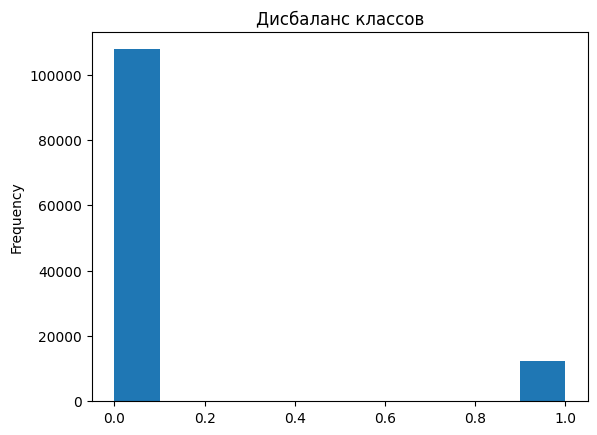

In [8]:
data['toxic'].plot(kind='hist', title='Дисбаланс классов');

#### Подготовка твитов

##### Токенизация

Инициализируем Spacy модель для английского языка:

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Токенизируем твиты:

In [10]:
token_twit = [nlp(x) for x in notebook.tqdm(data['text'])]

  0%|          | 0/120000 [00:00<?, ?it/s]

In [11]:
token_twit[0:3]

[" ""Rothbard himself relates that in the winter of 1949/50, in the course of a conversation with some left-wing students, he realised that it was impossible for him to support the free market in all fields and at the same time be in favour of a State police force, “my whole position was inconsistent [...], there were only two logical possibilities: socialism, or anarchism. Since it was out of the question for me to become a socialist, I found myself pushed by the irresistible logic of the case, a private property anarchist, or, as I would later dub it, an anarcho-capitalist” (Crocetta, Roberta Modugno, The anarcho-capitalist political theory of Murray N. Rothbard in its historical and intellectual context)",
 ...If that is okay by Rockpocket?,
 That sounds to me like an excellent solution.]

##### Лемматизация

Формируем леммы твитов:

In [12]:
lemma_twit = [" ".join([token.lemma_ for token in i]) for i in notebook.tqdm(token_twit)];

  0%|          | 0/120000 [00:00<?, ?it/s]

In [13]:
lemma_twit[0:3]

['" " " rothbard himself relate that in the winter of 1949/50 , in the course of a conversation with some left - wing student , he realise that it be impossible for he to support the free market in all field and at the same time be in favour of a State police force , " my whole position be inconsistent [ ... ] , there be only two logical possibility : socialism , or anarchism . since it be out of the question for I to become a socialist , I find myself push by the irresistible logic of the case , a private property anarchist , or , as I would later dub it , an anarcho - capitalist " ( Crocetta , Roberta Modugno , the anarcho - capitalist political theory of Murray N. Rothbard in its historical and intellectual context ) "',
 '... if that be okay by Rockpocket ?',
 'that sound to I like an excellent solution .']

##### Удаляем ненужные символы

Функция для удаления ненужных символов:

In [14]:
def clear_text(text):
    a = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    return ",".join(a.split())

In [15]:
clear_lemma_twit = [clear_text(w) for w in lemma_twit]

In [16]:
clear_lemma_twit[0:3]

['rothbard,himself,relate,that,in,the,winter,of,in,the,course,of,a,conversation,with,some,left,wing,student,he,realise,that,it,be,impossible,for,he,to,support,the,free,market,in,all,field,and,at,the,same,time,be,in,favour,of,a,state,police,force,my,whole,position,be,inconsistent,there,be,only,two,logical,possibility,socialism,or,anarchism,since,it,be,out,of,the,question,for,i,to,become,a,socialist,i,find,myself,push,by,the,irresistible,logic,of,the,case,a,private,property,anarchist,or,as,i,would,later,dub,it,an,anarcho,capitalist,crocetta,roberta,modugno,the,anarcho,capitalist,political,theory,of,murray,n,rothbard,in,its,historical,and,intellectual,context',
 'if,that,be,okay,by,rockpocket',
 'that,sound,to,i,like,an,excellent,solution']

**Облако слов**

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
text_raw = " ".join(clear_lemma_twit)

In [19]:
wordcloud = WordCloud().generate(text_raw)

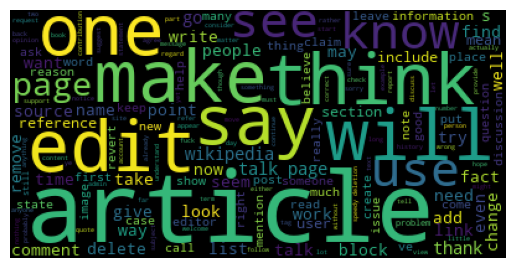

In [20]:
plt.imshow(wordcloud)
plt.axis('off');

Без стоп-слов:

In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
text_raw = [token for token in " ".join(clear_lemma_twit).split(',') if token not in stop_words]

In [23]:
text = " ".join(text_raw)
wordcloud = WordCloud().generate(text)

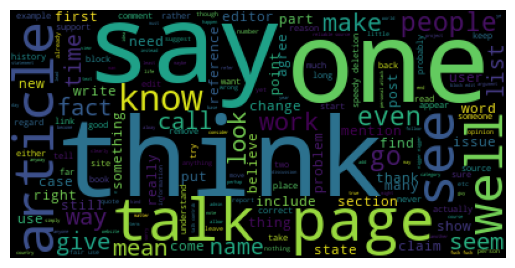

In [24]:
plt.imshow(wordcloud)
plt.axis('off');

**Частотный анализ**

In [25]:
text_raw = " ".join(clear_lemma_twit).split(',')
text = nltk.Text(text_raw)

In [26]:
fdist = FreqDist(text)

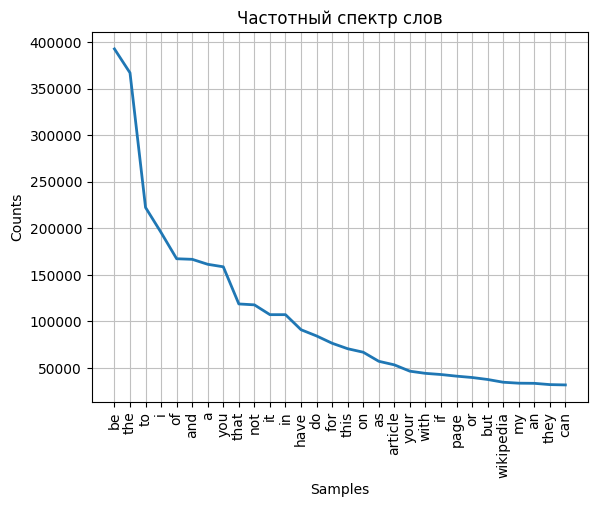

In [27]:
fdist.plot(30,cumulative=False, title='Частотный спектр слов');

Без стоп-слов:

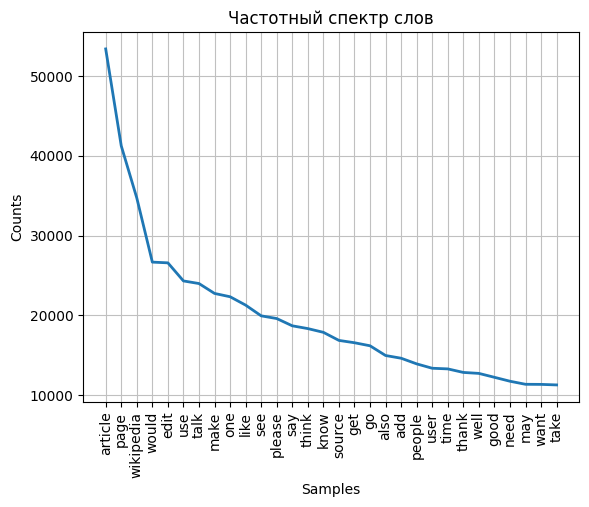

In [28]:
text_raw = [token for token in " ".join(clear_lemma_twit).split(',') if token not in stop_words]
text = nltk.Text(text_raw)
fdist = FreqDist(text)
fdist.plot(30,cumulative=False, title='Частотный спектр слов');

##### Формируем массивы нецелевых и целевого признаков:

Нецелевые признаки:

In [29]:
features = pd.DataFrame(clear_lemma_twit)

Целевой признак:

In [30]:
target = data['toxic']

##### Разделение на обучающую и тестовую выборки

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=12345, stratify=target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((90000, 1), (30000, 1), (90000,), (30000,))

### Промежуточные выводы

В ходе первого этапа:
- импортированы необходимые инструменты, загружен исходный датасет с твитами пользователей;
- проведена предобработка данных: проверено отсуствие дубликатов и пропусков;
- подготовлены твиты: токенизация и лемматизация твитов выполнена с помощью метода Spacy, удалены ненужные символы, сформированы массивы нецелевых и целевого признаков, которые затем разделены на обучающие и тестовые наборы, итоговые массивы признаков получены в виде значений параметра TF-IDF, рассчитываемого по корпусу обработанных твитов.

## Обучение

Исследуем модели: логистическая регрессия, случайный лес, градиентный бустинг GBM. 

Для подбора гиперпараметров используем оптимизатор Optuna. 

### LogisticRegression

In [41]:
%%time

def objective_cv(trial):    
    # Список гиперпараметров для LogisticRegression
    param = {
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear']),
        'C': trial.suggest_float('C', 0.1, 5.2, step=0.3),
        'class_weight': trial.suggest_categorical('class_weight',['balanced', None]),
    }

    # модель машинного обучения
    model = LogisticRegression(**param, verbose=False, random_state=12345)

    # пайплайн
    pipeline = Pipeline(steps=[
                                ('Tfidf', TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))),                             
                                ('model', model)
    ])
            
    # Код для вычисления метрики качества с помощью кросс-валидации
    F1_LR = cross_val_score(pipeline, X_train[0], y_train, scoring= 'f1').mean()
    return F1_LR

#optuna.logging.set_verbosity(optuna.logging.WARNING)
study_LR = optuna.create_study(direction='maximize')
study_LR.optimize(objective_cv, n_trials=7)
study_LR.best_params, study_LR.best_value

/Users/mihail/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mihail/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

CPU times: user 17min 51s, sys: 2min 20s, total: 20min 12s
Wall time: 10min 2s


({'solver': 'liblinear', 'C': 4.6, 'class_weight': 'balanced'},
 0.7736794483850129)

### RandomForestClassifier

In [42]:
%%time

def objective_cv(trial):
     
    # Список гиперпараметров для RandomForestClassifier
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 13, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 70, 100, step=30),
        'class_weight': trial.suggest_categorical('class_weight',['balanced', None]),
    }

    # модель машинного обучения
    model = RandomForestClassifier(**param, verbose=False, random_state=12345)

    # пайплайн
    pipeline = Pipeline(steps=[
                                ('Tfidf', TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))),                             
                                ('model', model)
    ])
                
    F1_RF = cross_val_score(pipeline, X_train[0], y_train, scoring='f1').mean()
    return F1_RF

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_RF = optuna.create_study(direction='maximize')
study_RF.optimize(objective_cv, n_trials=7)
study_RF.best_params, study_RF.best_value

CPU times: user 8min 27s, sys: 13.7 s, total: 8min 41s
Wall time: 8min 42s


({'max_depth': 9, 'n_estimators': 100, 'class_weight': 'balanced'},
 0.31465116087696)

### GradientBoostingClassifier

Прогоны модели убрал из-за большого времени расчета.

In [43]:
%%time

def objective_cv(trial):
     
    # Список гиперпараметров для RandomForestClassifier
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 5, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 10, 20, step=10),
    }

    # модель машинного обучения
    model = GradientBoostingClassifier(**param, verbose=False, random_state=12345)

    # пайплайн
    pipeline = Pipeline(steps=[
                                ('Tfidf', TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))),                             
                                ('model', model)
    ])
                
    F1_GBM = cross_val_score(pipeline, X_train[0], y_train, scoring='f1').mean()
    return F1_GBM

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_GBM = optuna.create_study(direction='maximize')
study_GBM.optimize(objective_cv, n_trials=1)
study_GBM.best_params, study_GBM.best_value

CPU times: user 6min 28s, sys: 3.25 s, total: 6min 31s
Wall time: 6min 33s


({'max_depth': 5, 'n_estimators': 10}, 0.4186538135451808)

Сформируем датафрейм и построим наглядный график с метрикой F1 для разных моделей:

In [44]:
df = pd.DataFrame(
   ....:     {
   ....:         'F1': [study_LR.best_value, study_RF.best_value, study_GBM.best_value]},
    index=['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier'],           
)

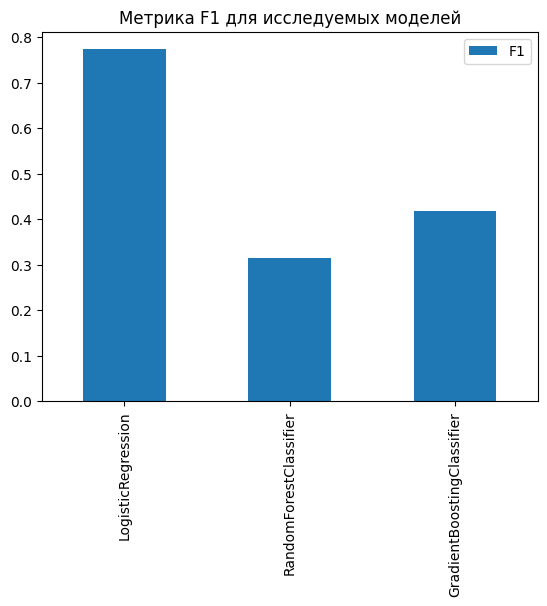

In [45]:
df.plot(kind='bar', title='Метрика F1 для исследуемых моделей');

### Промежуточные выводы

На втором этапе проведено обучение моделей:
- для обучения выбраны модели: логистическая регрессия, случайный лес, градиентный бустинг GBM;
- подбор гиперпараметров проведена с помощью оптимизатора optuna;
- лучшее значение метрики F1 получено на модели LogisticRegression(solver='liblinear', C=4.6, class_weight='balanced',verbose=False, random_state=12345), F1 ~ 0.77.

## Тестирование

### Тестовый расчет метрики качества F1 с помощью лучшей модели

In [46]:
model = LogisticRegression(solver='liblinear', C=4.6, class_weight='balanced',verbose=False, random_state=12345)
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))
X_train1 = count_tf_idf.fit_transform(X_train[0])
X_test1 = count_tf_idf.transform(X_test[0])
model.fit(X_train1, y_train)
prediction = model.predict(X_test1)
f1_score(y_test, prediction)

0.7797890760270738

In [47]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)


test_bert = data.sample(5000, weights='toxic', random_state=123)


y_pred = []
for text in notebook.tqdm(test_bert['text']):
    
    pred = pipeline(text[:512])
    y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)

f1_score(test_bert['toxic'], y_pred)

  0%|          | 0/5000 [00:00<?, ?it/s]

0.7378518238041146

### Проверка адекватности модели

Для проверки адекватности работы модели рассчитаем метрику F1 с помощью dummy-модели:

In [48]:
# создаем объект dummy со стратегией заполнения uniform
dummy_clf = DummyClassifier(strategy="uniform")
# обучаем на трейне
dummy_clf.fit(X_train[0], y_train)
# формируем предсказания
predict = dummy_clf.predict(X_test[0])
# считаем метрику
f1_score(y_test, predict)

0.16946160635481022

Метрика F1, рассчитанная с помощью Dummy-модели, оказалась намного хуже, что подтверждает адекватность выбранной модели.

In [49]:
# создаем объект dummy со стратегией заполнения uniform
dummy_clf = DummyClassifier(strategy = 'constant', constant = 1)# обучаем на трейне
dummy_clf.fit(X_train[0], y_train)
# формируем предсказания
predict = dummy_clf.predict(X_test[0])
# считаем метрику
f1_score(y_test, predict)

0.18495326254651057

### Промежуточные выводы

В ходе третьего этапа проведено тестирование лучшей модели:
- значение метрик F1 для выбранной модели составило 0.78, что удовлетворяет требуемому условию: F1 >= 0.75;
- адекватность модели проверена путем сравнения с dummy-моделью по значению метрики F1.

## Общие выводы

**Целью выполнения проекта** являлось обучение модели классифицировать комментарии на позитивные и негативные. В распоряжении имелся набор данных с разметкой о токсичности правок. Ограничения: модель должна иметь метрику качества F1 не меньше 0.75.

**В ходе первого этапа** проведена подготовка признаков для обучения моделей:
- импортированы необходимые инструменты, загружен исходный датасет с твитами пользователей;
- проведена предобработка данных: удален неинформативный признак Unnamed: 0, проверено отсуствие дубликатов и пропусков;
- подготовлены твиты: токенизация и лемматизация твитов выполнена с помощью метода Spacy, удалены ненужные символы, сформированы массивы нецелевых и целевого признаков, которые затем разделены на обучающие и тестовые наборы, итоговые массивы признаков получены в виде значений параметра TF-IDF, рассчитываемого по корпусу обработанных твитов.

**На втором этапе** проведено обучение моделей:
- для обучения выбраны модели: логистическая регрессия, случайный лес, градиентный бустинг GBM;
- подбор гиперпараметров проведена с помощью оптимизатора optuna;
- лучшее значение метрики F1 получено на модели LogisticRegression(solver='liblinear', C=4.6, class_weight='balanced',verbose=False, random_state=12345), F1 = 0.77.

**В ходе третьего этапа** проведено тестирование лучшей модели:
- значение метрик F1 для выбранной модели составило 0.78, что удовлетворяет требуемому условию: F1 >= 0.75;
- адекватность модели проверена путем сравнения с dummy-моделью по значению метрики F1.

**Таким образом,** для классификации твитов предлагается использовать модель LogisticRegression с гиперпараметрами (solver='liblinear', C=4.6, class_weight='balanced',verbose=False, random_state=12345), которая обеспечивает метрику качества F1 = 0.78, удовлетворяющую критерию F1 >= 0.75.

##  Выводы для начальства

Для классификации комментариев пользователей к описанию товаров на негативные и позитивные предлагается использовать модель LogisticRegression с гиперпараметрами (solver='liblinear', C=4.6, class_weight='balanced',verbose=False, random_state=12345), которая обеспечивает метрику качества F1 = 0.78, удовлетворяющую условию F1 >= 0.75.